In [18]:
import torch
import os
import pandas as pd
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torch.nn import functional as F
from tqdm import tqdm
from PIL import Image

# 数据查看

In [3]:
train_df = pd.read_csv("./data/train.csv")
val_df = pd.read_csv("./data/test.csv")

label_counts = train_df['label'].value_counts()

print(train_df.shape, '\n')
print(train_df.info(), '\n')
print(train_df.describe(), '\n')
print(train_df.head(), '\n')

(18353, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18353 entries, 0 to 18352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18353 non-null  object
 1   label   18353 non-null  object
dtypes: object(2)
memory usage: 286.9+ KB
None 

               image             label
count          18353             18353
unique         18353               176
top     images/0.jpg  maclura_pomifera
freq               1               353 

          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera 



## 饼状图

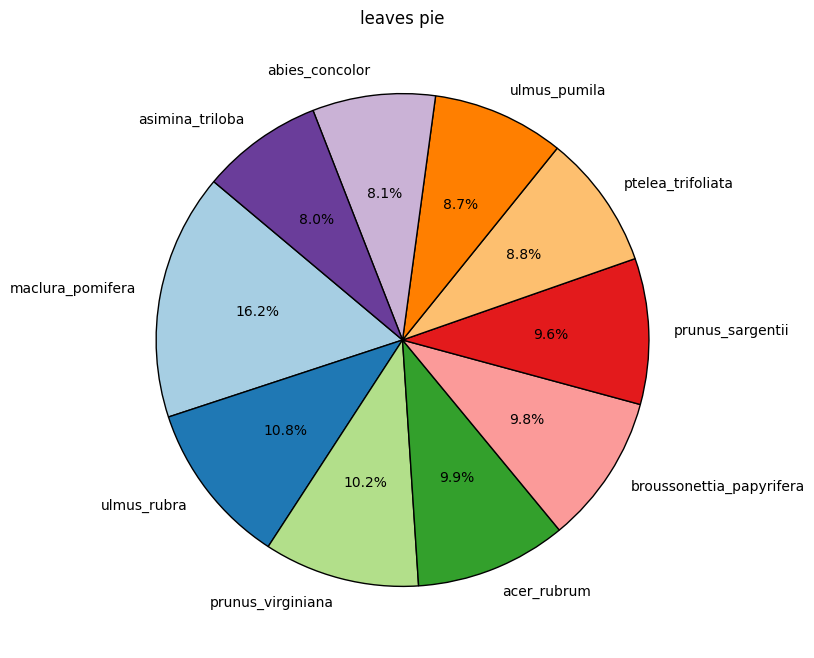

In [4]:
plt.figure(figsize=(8,8))
plt.pie(
    label_counts.values[:10],
    labels = label_counts.index[:10],
    autopct='%1.1f%%',
    colors=plt.cm.Paired.colors,
    startangle=140,
    wedgeprops={'edgecolor': 'black'} 
)

plt.title("leaves pie")

plt.show()

## 直方图

/tmp/ipykernel_58411/1721584164.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index[:30], y=label_counts.values[:30], palette="viridis")  # 只画前30个类别


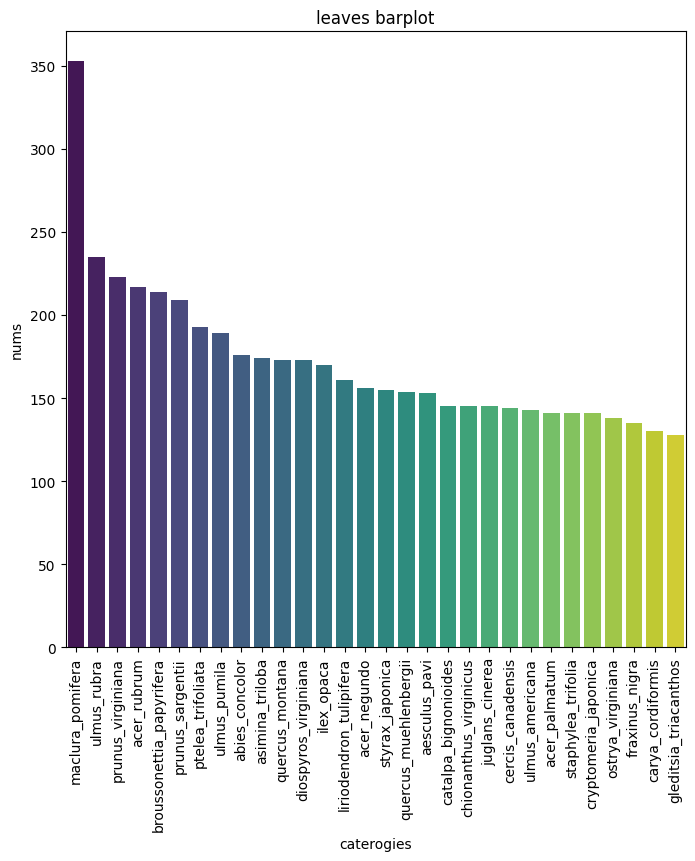

In [5]:
plt.figure(figsize=(8, 8)) 
sns.barplot(x=label_counts.index[:30], y=label_counts.values[:30], palette="viridis")  # 只画前30个类别
plt.xticks(rotation=90)  # 旋转x轴标签，防止重叠
plt.xlabel("caterogies")
plt.ylabel("nums")
plt.title("leaves barplot")

# 显示图像
plt.show()

## 预览图片

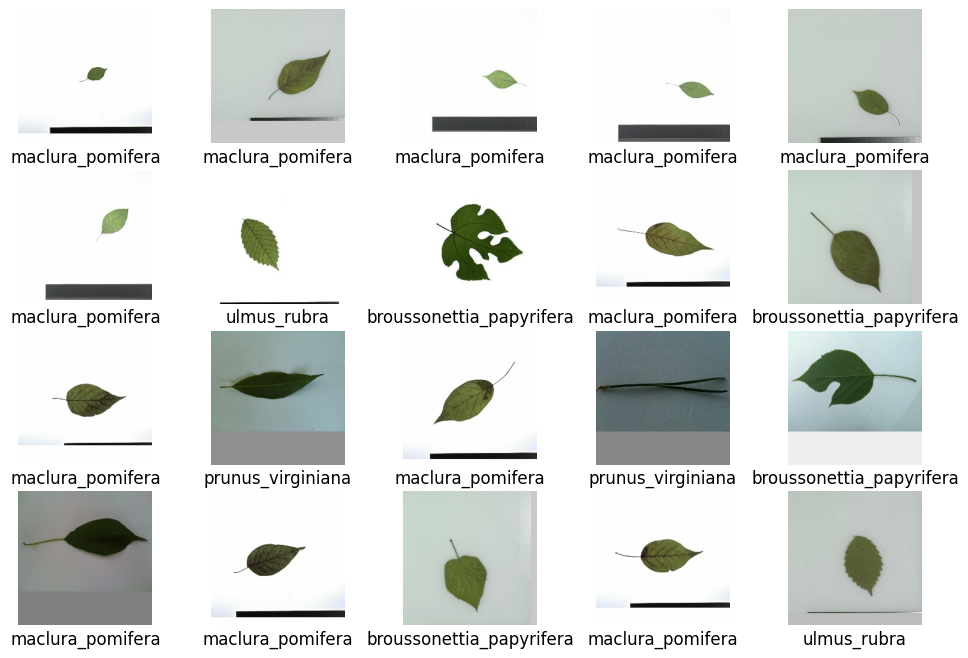

In [6]:
preview_image_paths = train_df['image'][:20]
preview_image_labels = train_df['label'][:20]

fig, axes = plt.subplots(4, 5, figsize=(12,8))

for i, (ax,img_path) in enumerate(zip(axes.flatten(), preview_image_paths)):
    img = mpimg.imread(os.path.join("./data", img_path))  # 读取图片
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(preview_image_labels[i],y=-0.2)

plt.show()

# 准备数据

In [7]:
unique_labels = train_df["label"].unique()

label2idx = {label : idx for idx, label in enumerate(unique_labels)}
idx2label = {v : k for k, v in label2idx.items()}

## 自定义dataset

In [8]:
class LeaveDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join('./data', self.data.iloc[idx,0])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)  # 应用转换
        
        label_name = self.data.iloc[idx,1]
        label = label2idx[label_name]  # 转换为整数索引

        return image, label  # 返回 (图片, 标签)

## 封装DataLoader

In [9]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = LeaveDataset(train_df, transform)

total_size = len(train_dataset)
test_size = int(0.2 * total_size)
train_size = total_size-test_size

train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4)

print("总批次：", len(train_loader))

总批次： 115


# 定义模型

In [10]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

num_classes = len(label_counts)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

resnet = resnet.to(device)
resnet

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 损失函数和优化器

In [11]:
criterion = nn.CrossEntropyLoss()

lr, momentum = 0.01, 0.9

optimizer = optim.SGD(resnet.parameters(), lr=lr, momentum=momentum)


# 训练模型

In [20]:
def train():
    resnet.train()

    batch_nums = len(train_loader)
    batch_size = train_loader.batch_size
    size = len(train_loader.dataset)
    
    train_loss,correct = 0.0, 0.0 
    p = tqdm(train_loader, desc="Training", unit="batch")

    for X,y in p:
        X,y = X.to(device), y.to(device)
        pred = resnet(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        p.set_postfix(loss=f"{loss.item():>8f}")

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()

    train_loss /=  batch_nums
    print(f"batch_nums: {batch_nums}")
    correct /= size
    print(f"Train Accuracy: {(100*correct):>0.2f}%, Train Avg loss:{train_loss:>8f}")


    return train_loss, correct        

In [21]:
def test():
    resnet.eval() # 评估模式
    
    batch_nums = len(test_loader)  # 批次数
    batch_size = test_loader.batch_size  # 批量大小
    size = len(test_loader.dataset)  # 数据集大小
    
    test_loss,correct = 0.0, 0.0 # 统计损失和准确率

    with torch.no_grad():
        
        for X,y in test_loader:
            X,y = X.to(device),y.to(device)
            pred = resnet(X)
            loss = criterion(pred,y)

            test_loss+=loss.item() # 累计每个批次的平均损失
            correct += (pred.argmax(1) == y).sum().item() # 计算正确预测的数量

    test_loss /= batch_nums
    correct /= size
    print(f"Test Accuracy: {(100*correct):>0.1f}%, Test Avg loss: {test_loss:>8f}")
    
    return test_loss,correct

In [22]:
train_losses, train_accs = [],[]

test_losses, test_accs = [],[]

epochs = 20

best_acc = 0.0
save_path = 'best model.pth'

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    train_loss, train_acc = train()
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_loss,test_acc = test()
    test_losses.append(test_loss)
    test_accs.append(test_acc)  

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(resnet.state_dict(), save_path)  # 仅保存状态字典
        print(f'New best model saved with accuracy: {best_acc:.4f}')

    print("-"*30)
    

Epoch 1


Training: 100%|██████████| 115/115 [00:16<00:00,  6.97batch/s, loss=1.226092]

batch_nums: 115
Train Accuracy: 39.32%, Train Avg loss:2.859308


Test Accuracy: 64.8%, Test Avg loss: 1.502584
New best model saved with accuracy: 0.6477
------------------------------
Epoch 2


Training: 100%|██████████| 115/115 [00:11<00:00, 10.29batch/s, loss=0.651054]

batch_nums: 115
Train Accuracy: 81.26%, Train Avg loss:0.840049


Test Accuracy: 79.6%, Test Avg loss: 0.808617
New best model saved with accuracy: 0.7956
------------------------------
Epoch 3


Training: 100%|██████████| 115/115 [00:11<00:00, 10.24batch/s, loss=0.410691]

batch_nums: 115
Train Accuracy: 92.05%, Train Avg loss:0.383024


Test Accuracy: 85.5%, Test Avg loss: 0.562350
New best model saved with accuracy: 0.8550
------------------------------
Epoch 4


Training: 100%|██████████| 115/115 [00:11<00:00, 10.27batch/s, loss=0.250603]

batch_nums: 115
Train Accuracy: 96.59%, Train Avg loss:0.197936


Test Accuracy: 87.5%, Test Avg loss: 0.474536
New best model saved with accuracy: 0.8755
------------------------------
Epoch 5


Training: 100%|██████████| 115/115 [00:11<00:00,  9.97batch/s, loss=0.111801]

batch_nums: 115
Train Accuracy: 98.44%, Train Avg loss:0.104625


Test Accuracy: 90.8%, Test Avg loss: 0.346311
New best model saved with accuracy: 0.9082
------------------------------
Epoch 6


Training: 100%|██████████| 115/115 [00:11<00:00,  9.85batch/s, loss=0.130410]

batch_nums: 115
Train Accuracy: 98.96%, Train Avg loss:0.066559


Test Accuracy: 89.8%, Test Avg loss: 0.383130
------------------------------
Epoch 7


Training: 100%|██████████| 115/115 [00:11<00:00, 10.32batch/s, loss=0.030074]

batch_nums: 115
Train Accuracy: 99.18%, Train Avg loss:0.045532


Test Accuracy: 92.8%, Test Avg loss: 0.242649
New best model saved with accuracy: 0.9281
------------------------------
Epoch 8


Training: 100%|██████████| 115/115 [00:11<00:00,  9.73batch/s, loss=0.053062]

batch_nums: 115
Train Accuracy: 99.23%, Train Avg loss:0.035561


Test Accuracy: 93.0%, Test Avg loss: 0.234098
New best model saved with accuracy: 0.9297
------------------------------
Epoch 9


Training: 100%|██████████| 115/115 [00:11<00:00, 10.27batch/s, loss=0.021086]

batch_nums: 115
Train Accuracy: 99.24%, Train Avg loss:0.029834


Test Accuracy: 93.8%, Test Avg loss: 0.220646
New best model saved with accuracy: 0.9376
------------------------------
Epoch 10


Training: 100%|██████████| 115/115 [00:11<00:00, 10.14batch/s, loss=0.048489]

batch_nums: 115
Train Accuracy: 99.23%, Train Avg loss:0.027153


Test Accuracy: 93.9%, Test Avg loss: 0.213318
New best model saved with accuracy: 0.9392
------------------------------
Epoch 11


Training: 100%|██████████| 115/115 [00:11<00:00, 10.06batch/s, loss=0.017328]

batch_nums: 115
Train Accuracy: 99.26%, Train Avg loss:0.023973


Test Accuracy: 94.4%, Test Avg loss: 0.203691
New best model saved with accuracy: 0.9444
------------------------------
Epoch 12


Training: 100%|██████████| 115/115 [00:11<00:00, 10.14batch/s, loss=0.073408]

batch_nums: 115
Train Accuracy: 99.23%, Train Avg loss:0.023165


Test Accuracy: 93.8%, Test Avg loss: 0.206904
------------------------------
Epoch 13


Training: 100%|██████████| 115/115 [00:11<00:00, 10.16batch/s, loss=0.015344]

batch_nums: 115
Train Accuracy: 99.26%, Train Avg loss:0.021507


Test Accuracy: 93.7%, Test Avg loss: 0.208847
------------------------------
Epoch 14


Training: 100%|██████████| 115/115 [00:11<00:00, 10.20batch/s, loss=0.014694]

batch_nums: 115
Train Accuracy: 99.33%, Train Avg loss:0.019628


Test Accuracy: 94.1%, Test Avg loss: 0.197215
------------------------------
Epoch 15


Training: 100%|██████████| 115/115 [00:11<00:00, 10.30batch/s, loss=0.004889]

batch_nums: 115
Train Accuracy: 99.31%, Train Avg loss:0.019301


Test Accuracy: 94.1%, Test Avg loss: 0.197432
------------------------------
Epoch 16


Training: 100%|██████████| 115/115 [00:11<00:00, 10.09batch/s, loss=0.026274]

batch_nums: 115
Train Accuracy: 99.22%, Train Avg loss:0.018698


Test Accuracy: 94.2%, Test Avg loss: 0.196936
------------------------------
Epoch 17


Training: 100%|██████████| 115/115 [00:11<00:00, 10.22batch/s, loss=0.008311]

batch_nums: 115
Train Accuracy: 99.31%, Train Avg loss:0.017665


Test Accuracy: 94.0%, Test Avg loss: 0.199841
------------------------------
Epoch 18


Training: 100%|██████████| 115/115 [00:11<00:00, 10.20batch/s, loss=0.046726]

batch_nums: 115
Train Accuracy: 99.31%, Train Avg loss:0.017018


Test Accuracy: 94.2%, Test Avg loss: 0.203461
------------------------------
Epoch 19


Training: 100%|██████████| 115/115 [00:11<00:00, 10.23batch/s, loss=0.008751]

batch_nums: 115
Train Accuracy: 99.29%, Train Avg loss:0.016619


Test Accuracy: 93.9%, Test Avg loss: 0.195376
------------------------------
Epoch 20


Training: 100%|██████████| 115/115 [00:11<00:00,  9.92batch/s, loss=0.024662]

batch_nums: 115
Train Accuracy: 99.26%, Train Avg loss:0.016319


Test Accuracy: 94.0%, Test Avg loss: 0.193570
------------------------------


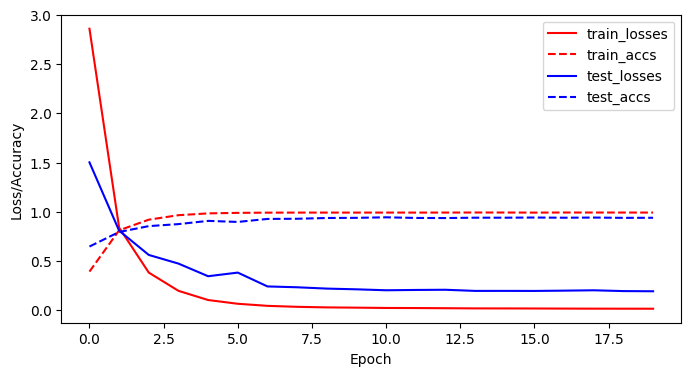

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, "r-", label="train_losses")
plt.plot(train_accs, "r--", label="train_accs")
plt.plot(test_losses, "b-", label="test_losses")
plt.plot(test_accs, "b--", label="test_accs")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# 加载最优模型


In [24]:
# 重新定义模型（确保架构一致）
resnet = models.resnet18()
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)

# 加载训练好的权重
resnet.load_state_dict(torch.load(save_path,weights_only=True))

# 切换到 eval 模式
resnet.to(device)
resnet.eval()
print("模型已加载并设置为评估模式！")

模型已加载并设置为评估模式！


# 预测数据

In [26]:
resnet.eval()

# 单张图片预测
img_val_path = os.path.join('./data',val_df['image'][0])
image_val = Image.open(img_val_path)
image_val_tensor = transform(image_val).unsqueeze(0)  # 应用转换 升维

# 预测
with torch.no_grad():
    image_val_tensor = image_val_tensor.to(device)
    output = resnet(image_val_tensor)
    probabilities = F.softmax(output, dim=1)  # 转换为概率
    pred_class = torch.argmax(probabilities).item()

print(torch.max(probabilities).item()*100,'%')
print(idx2label[pred_class])

99.26007390022278 %
asimina_triloba


In [30]:
# 批量预测

class LeaveValDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join('./data', self.data.iloc[idx,0])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)  # 应用转换
        
        return image

val_dataset = LeaveValDataset(val_df,transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print("val batch num:",len(val_loader))

val batch num: 69


In [31]:
all_preds = []

with torch.no_grad():
    for inputs in tqdm(val_loader):
        inputs = inputs.to(device)
        outputs = resnet(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())

print("批量预测结果长度:", len(all_preds))

100%|██████████| 69/69 [00:03<00:00, 19.19it/s]

批量预测结果长度: 8800


In [32]:
pred_labels = [idx2label[pred_id] for pred_id in all_preds] # 转换成label
val_df['label'] = pred_labels
val_df.to_csv('submission.csv',index=False)